In [1]:
import os, sys
import sys
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from  matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import librosa
import IPython.display as ipd
from numba import jit
sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c3
import libfmp.c6
%matplotlib inline
import pandas as pd


### Noções Básicas e Premissas
Regularidades temporais e estruturais são talvez os incentivos mais importantes para que as pessoas se envolvam e interajam com a música. É o ritmo que impulsiona a música e fornece a estrutura temporal de uma peça musical. Intuitivamente, a batida corresponde ao pulso que uma pessoa bate ao ouvir música. A batida é frequentemente descrita como uma sequência de posições de pulso percebidas, que são tipicamente espaçadas igualmente no tempo e especificadas por dois parâmetros: a fase e o período. O termo tempo refere-se à taxa do pulso e é dado pelo recíproco do período da batida. 

A extração de informações de tempo e ritmo a partir de gravações de áudio é um problema desafiador, especialmente para músicas com inícios de notas fracos e mudanças locais de tempo. Por exemplo, no caso da música de piano romântica, o pianista frequentemente toma a liberdade de acelerar e desacelerar o tempo — um meio artístico também referido como **tempo rubato**. Existe uma ampla gama de músicas onde as noções de tempo e ritmo permanecem bastante vagas ou são até inexistentes. Às vezes, o fluxo rítmico da música é deliberadamente interrompido ou perturbado pela sincopação, onde certas notas fora da grade regular das posições de batida são enfatizadas.

Para tornar o problema de rastreamento de tempo e ritmo viável, a maioria das abordagens automatizadas baseia-se em duas suposições básicas.

- A primeira suposição é que as posições de ritmo ocorrem nas posições de início das notas.
- A segunda suposição é que as posições de ritmo são mais ou menos igualmente espaçadas — pelo menos por um certo período de tempo.

Embora ambas as suposições possam ser violadas e inapropriadas para certos tipos de música, elas são convenientes e razoáveis para uma ampla gama de músicas, incluindo a maioria das canções de rock e músicas populares.

### Representações de Tempograma

Em análise de Fourier, um espectrograma (de magnitude) é uma representação tempo-frequência de um dado sinal. Um valor grande $Y(t, \omega)$ de um espectrograma indica que o sinal contém, no instante $t$, um componente periódico que corresponde à frequência $\omega$. Agora, introduzimos um conceito semelhante, denominado tempograma, que indica, para cada instante de tempo, a relevância local de um tempo específico para uma determinada gravação musical. Matematicamente, modelamos um tempograma como uma função
$$T : \mathbb{R} \times \mathbb{R}_{>0} \to \mathbb{R}_{\geq 0}$$
dependendo de um parâmetro de tempo $t \in \mathbb{R}$ medido em segundos e um parâmetro de tempo $\tau \in \mathbb{R}_{>0}$ medido em batidas por minuto (BPM). Intuitivamente, o valor $T(t, \tau)$ indica a extensão em que o sinal contém um pulso periódico local de um dado tempo $\tau$ em uma vizinhança do instante de tempo $t$. Assim como nos espectrogramas, um tempograma é calculado na prática apenas em uma grade de **tempo-tempo** discreta. Como antes, assumimos que o eixo de tempo amostrado é dado por $[1:N]$. Para evitar casos de fronteira e simplificar a notação nas considerações subsequentes, estendemos esse eixo para $\mathbb{Z}$. Além disso, seja $\Theta \subset \mathbb{R}_{>0}$ um conjunto finito de tempos especificados em BPM. Então, um tempograma discreto é uma função
$$T : \mathbb{Z} \times \Theta \to \mathbb{R}_{\geq 0}.$$
A maioria das abordagens para derivar uma representação de tempograma a partir de uma gravação de áudio procede em duas etapas.

- Com base na suposição de que as posições dos pulsos geralmente acompanham os inícios das notas, o sinal musical é primeiro convertido em uma função de novidade. Esta função tipicamente consiste em picos impulsivos, cada um indicando uma posição de início de nota.
- Na segunda etapa, o comportamento periódico local da função de novidade é analisado.

Para obter um tempograma, quantifica-se o comportamento periódico para vários períodos $T>0$ (dados em segundos) em uma vizinhança de um determinado instante de tempo. A taxa $\omega = 1/T$ (medida em Hz) e o tempo $\tau$ (medido em BPM) estão relacionados por
$$\tau = 60 \cdot \omega.$$
Por exemplo, uma sequência de picos impulsivos que estão regularmente espaçados com um período $T = 0.5$ segundos corresponde a uma taxa de $\omega = 1/T = 2$ Hz ou a um tempo de $\tau = 120$ BPM.

### Níveis de Pulso

Um dos principais problemas na determinação do tempo de uma gravação musical surge do fato de que os pulsos na música frequentemente são organizados em hierarquias complexas que representam o ritmo. Em particular, existem vários níveis que se presume contribuir para a percepção humana do tempo e do ritmo. O nível de **tactus** normalmente corresponde ao nível de semínima e frequentemente coincide com a taxa de batida do pé. Pensando em uma escala musical maior, pode-se também perceber o tempo ao nível da medida, especialmente ao ouvir música rápida ou música altamente expressiva com forte **rubato**. Finalmente, pode-se também considerar o nível de tatum (átomo temporal), que se refere à taxa de repetição mais rápida de acentos musicalmente significativos que ocorrem no sinal.

### Oitava de Tempo, Harmônico e Sub-harmônico

Frequentemente, a ambiguidade do tempo que surge da existência de diferentes níveis de pulso também se reflete em um tempograma $T$. Níveis de pulso mais altos frequentemente correspondem a múltiplos inteiros $\tau, 2\tau, 3\tau, \ldots$ de um dado tempo $\tau$. Assim como com a altura tonal, chamamos esses múltiplos inteiros de **harmônicos (de tempo)** de $\tau$. Além disso, frações inteiras $\tau, \tau/2, \tau/3, \ldots$ são referidas como **sub-harmônicos (de tempo)** de $\tau$. Análogo à noção de uma oitava para alturas musicais, a diferença entre dois tempos com metade ou o dobro do valor é chamada de oitava de tempo.

### Tempo Global

Assumindo um tempo mais ou menos constante, basta determinar um valor de tempo global para toda a gravação. Esse valor pode ser obtido pela média dos valores de tempo obtidos a partir de uma análise de periodicidade quadro a quadro. Por exemplo, com base em uma representação de tempograma, pode-se fazer a média dos valores de tempo ao longo de todos os quadros temporais para obter uma função $T_{Average} : \Theta \to \mathbb{R}_{\geq 0}$ que depende apenas de $\tau \in \Theta$. Assumindo que as posições temporais relevantes estejam no intervalo $[1:N]$, pode-se definir $T_{Average}$ por
$$T_{Average}(\tau) := \frac{1}{N} \sum_{n \in [1:N]} T(n, \tau)$$

O máximo

$$\hat{\tau} := \max \{ T_{Average}(\tau) \mid \tau \in \Theta \}$$

dessa função então fornece uma estimativa para o tempo global da gravação. É claro que métodos mais refinados para estimar um único valor de tempo podem ser aplicados. Por exemplo, em vez de usar uma média simples, pode-se aplicar uma filtragem de mediana, que é mais robusta a outliers e ruídos.

# tempograma de Fourier
### Definição
Assumimos que nos é dada uma função de novidade discreta $\Delta : \mathbb{Z} \to \mathbb{R}$ na qual os picos indicam candidatos a início de notas. A ideia da análise de Fourier é detectar periodicidades localmente no sinal comparando-o com janelas senoidais. Uma alta correlação de uma seção local de $\Delta$ com uma janela senoidal indica uma periodicidade da frequência da senóide (dada uma fase adequada). Essa correlação (ao longo da fase) pode ser calculada usando uma transformada de Fourier de curto prazo (FFT). Para isso, fixamos uma função de janela $w : \mathbb{Z} \to \mathbb{R}$ de comprimento finito centrada em $n = 0$ (por exemplo, uma janela de Hann). Então, para um parâmetro de frequência $\omega \in \mathbb{R}_{\geq 0}$ e um parâmetro de tempo $n \in \mathbb{Z}$, o coeficiente de Fourier $F_\Delta(n, \omega)$ é definido por

$$F_\Delta(n, \omega) := \sum_{m \in \mathbb{Z}} \Delta(m) w(m - n) \exp(-2\pi i \omega m).$$

Essa definição é similar a uma transformada discreta de Fourier de curto prazo quando se usa um tamanho de hop $H = 1$. Convertendo a frequência para valores de tempo, definimos o tempograma de Fourier (discreto) $\mathcal{T}^F : \mathbb{Z} \times \Theta \to \mathbb{R}_{\geq 0}$ como

$$\mathcal{T}^F(n, \tau) := |F_\Delta(n, \tau/60)|.$$

Para aplicações práticas, $\mathcal{T}^F$ é calculado apenas para um pequeno número de parâmetros de tempo. Por exemplo, pode-se escolher o conjunto $\Theta = [30 : 600]$ cobrindo a gama de tempos musicais (inteiros) entre $30$ BPM e $600$ BPM. Essas escolhas são motivadas pela suposição de que apenas eventos musicais com uma separação temporal entre aproximadamente $100$ msec ($600$ BPM) e $2$ sec ($30$ BPM) contribuem para a percepção do tempo. Dependendo da aplicação específica e da natureza do sinal musical, uma janela que cobre de $4$ a $12$ segundos de áudio é uma faixa razoável. Além disso, a taxa de amostragem da função de novidade resultante pode ser ajustada introduzindo um parâmetro de hop $H$.

### Resolução do Tempo

Usar um conjunto de tempo como $\Theta = [30 : 600]$ requer uma análise espectral de alta resolução — em particular na faixa de frequência mais baixa. Por exemplo, assumimos que a função de novidade de entrada $\Delta$ tem uma taxa de amostragem de recurso $F_\Delta^A = 100$ Hz e que o comprimento da janela $w$ é $N = 1000$ (cobrindo 10 segundos da função de novidade $\Delta$). Então, simplesmente aplicando uma DFT de tamanho $N$, obteríamos os coeficientes de Fourier correspondentes às frequências físicas

$$\omega = F_{\text{coef}}(k) = \frac{k \cdot F_\Delta^A}{N} = k \cdot 0.1 \text{ Hz}$$

para $k \in [0 : 500]$, o que corresponde aos tempos $\tau = k \cdot 6$ BPM. Em outras palavras, a DFT renderia uma resolução de tempo de $6$ BPM com valores de tempo variando de $\tau = 0$ até $\tau = 3000$ BPM. Se estamos interessados em um conjunto de tempos específico como $\Theta = [30 : 600]$, apenas uma pequena fração dos coeficientes de Fourier (com $k \in [5 : 100]$) é necessária. Além disso, a resolução do tempo de $6$ BPM não é suficiente. Portanto, uma STFT direta baseada na DFT pode não ser adequada. Uma alternativa é computar os coeficientes de Fourier requeridos individualmente (sem usar a DFT). Mesmo que isso não possa ser feito via a abordagem DFT, a complexidade computacional pode ainda ser razoável uma vez que apenas um número relativamente pequeno de coeficientes de Fourier (correspondendo ao conjunto de tempos $\Theta$) precisa ser computado.

### Implementação

Abaixo, fornecemos uma implementação que está próxima da fórmula

$$F_\Delta(n, \omega) := \sum_{m \in \mathbb{Z}} \Delta(m) w(m - n) \exp(-2\pi i \omega m).$$

Assume-se que a função de novidade $\Delta$ tem comprimento $L \in \mathbb{N}$. Como função de janela $w$, escolhemos uma janela de Hann de comprimento $N \in \mathbb{N}$, que é deslocada pelo parâmetro de hop $H \in \mathbb{N}$. Seguindo, usamos uma visão centralizada, onde a função de novidade possa por zero-padding pela metade do comprimento da janela. Como resultado, o primeiro quadro $F_\Delta$ indexado por $n = 0$ corresponde ao tempo físico $t = 0$ seg. Note que o parâmetro de hop $H$ reduz a taxa de quadro do tempograma para $F_\Delta^A / H$ por segundo. Como pode-se ver, escolhemos qualquer conjunto finito de $\tau$ que nossa análise abranja um laço externo iterando sobre $\tau \in \Theta$. Para cada frequência $\omega = \tau/60$, os valores $F_\Delta(n, \omega)$ são então computados por um laço interno iterando sobre os índices de quadro $n$.

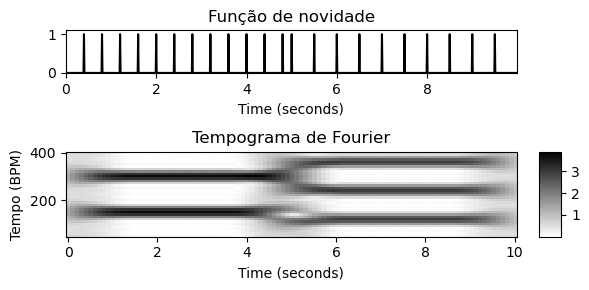

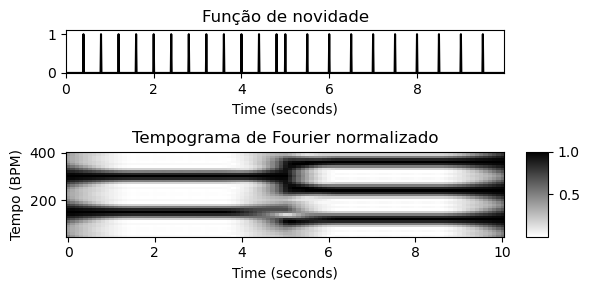

In [2]:
@jit(nopython=True)
def compute_tempogram_fourier(x, Fs, N, H, Theta=np.arange(30, 601, 1)):
    """ Computa o tempograma baseado em Fourier
    Args:
        x (np.ndarray): Sinal de entrada
        Fs (scalar): Taxa de amostragem
        N (int): Comprimento da janela
        H (int): Tamanho do passo (hop size)
        Theta (np.ndarray): Conjunto de tempo (dado em BPM) (Valor padrão = np.arange(30, 601, 1))
    Return:
        X (np.ndarray): Tempograma
        T_coef (np.ndarray): Eixo temporal (segundos)
        F_coef_BPM (np.ndarray): Eixo de tempos (BPM) """
    # Cria a janela de Hann
    win = np.hanning(N)
    N_left = N // 2
    L = x.shape[0]
    L_left = N_left
    L_right = N_left
    L_pad = L + L_left + L_right
    
    # Cria uma versão "padded" do sinal de entrada
    x_pad = np.concatenate((np.zeros(L_left), x, np.zeros(L_right)))
    t_pad = np.arange(L_pad)
    
    # Calcula o número de segmentos que serão extraídos do sinal "padded"
    M = int(np.floor(L_pad - N) / H) + 1
    
    # Número de diferentes tempo (BPM) a serem analisados
    K = len(Theta)
    
    # Inicializa o tempograma como uma matriz de zeros complexos
    X = np.zeros((K, M), dtype=np.complex_)

    # Loop para cada tempo (BPM)
    for k in range(K):
        # Calcula a frequência angular correspondente ao tempo (BPM)
        omega = (Theta[k] / 60) / Fs
        # Cria uma exponencial complexa para modulação de frequência
        exponential = np.exp(-2 * np.pi * 1j * omega * t_pad)
        # Modula o sinal "padded" pela exponencial
        x_exp = x_pad * exponential
        
        # Loop para cada segmento de tempo
        for n in range(M):
            t_0 = n * H
            t_1 = t_0 + N
            # Calcula a soma ponderada pela janela do segmento modulado
            X[k, n] = np.sum(win * x_exp[t_0:t_1])

    # Cria o eixo temporal em segundos
    T_coef = np.arange(M) * H / Fs
    # Usa os tempos fornecidos como o eixo de BPM
    F_coef_BPM = Theta
    
    return X, T_coef, F_coef_BPM


# A curva consiste em uma faixa de clique, que tem um tempo de 150 BPM em sua primeira metade e um tempo de 120 BPM em sua segunda metade.
Fs = 100
L = 10*Fs
x = np.zeros(L)
peaks = np.concatenate((np.arange(40,L//2,40),np.arange(500,L,50)))
x[peaks]=1
N = 300
H = 10
Theta = np.arange(50,410,10)

X, T_coef, F_coef_BPM = compute_tempogram_fourier(x, Fs, N=N, H=H, Theta=Theta)
tempogram = np.abs(X)
fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.05], 'height_ratios': [1, 2]}, figsize=(6, 3))        
libfmp.b.plot_signal(x, Fs, ax=ax[0,0], color='k', title='Função de novidade')
ax[0,1].set_axis_off()
libfmp.b.plot_matrix(tempogram, T_coef=T_coef, F_coef=F_coef_BPM, ax=[ax[1,0], ax[1,1]], title='Tempograma de Fourier', ylabel='Tempo (BPM)', colorbar=True);
plt.tight_layout()

X, T_coef, F_coef_BPM = compute_tempogram_fourier(x, Fs, N=N, H=H, Theta=Theta)
tempogram = np.abs(X)
tempogram = libfmp.c3.normalize_feature_sequence(tempogram, norm='max')
fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.05], 'height_ratios': [1, 2]}, figsize=(6, 3))        
libfmp.b.plot_signal(x, Fs, ax=ax[0,0], color='k', title='Função de novidade')
ax[0,1].set_axis_off()
libfmp.b.plot_matrix(tempogram, T_coef=T_coef, F_coef=F_coef_BPM, ax=[ax[1,0], ax[1,1]], title='Tempograma de Fourier normalizado', ylabel='Tempo (BPM)', colorbar=True);
plt.tight_layout()


A visualização do tempograma de Fourier $\mathcal{T}^F$ revela o tempo dominante ao longo do tempo. De fato, há valores altos para $\tau = 150$ BPM nos primeiros cinco segundos e valores altos para o tempo $\tau = 120$ BPM nos últimos cinco segundos. Baseado em uma análise de Fourier, uma entrada $\mathcal{T}^F(n, \tau)$ é obtida comparando localmente a função de novidade $\Delta$ em uma vizinhança de $n$ com uma sinusoide em janela que representa o tempo $\tau$ (ou a frequência $\omega = \tau / 60$).

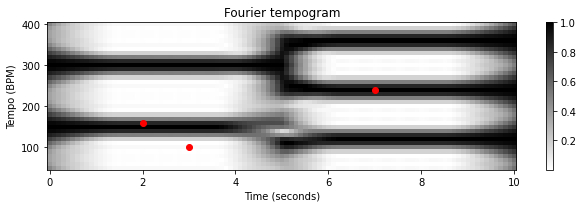

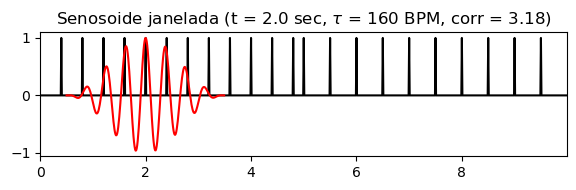

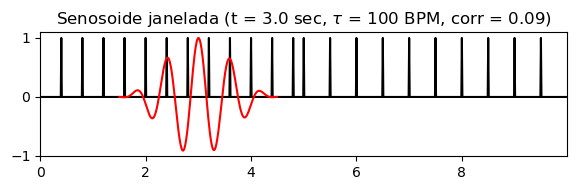

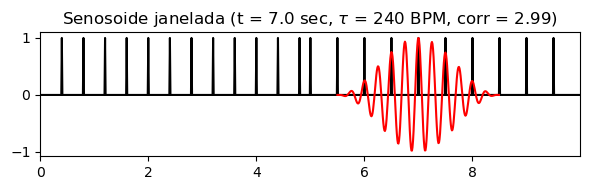

In [3]:
def compute_sinusoid_optimal(c, tempo, n, Fs, N, H):
    """ Calcula a sinusóide "janelada" e fase ótima
    Args:
        c (complex): Coeficiente do tempograma (c=X(k,n))
        tempo (float): Parâmetro de tempo correspondente a c (tempo=F_coef_BPM[k])
        n (int): Parâmetro de frame de c
        Fs (scalar): Taxa de amostragem
        N (int): Comprimento da janela
        H (int): Tamanho do passo (hop size)
    Retorna:
        kernel (np.ndarray): Sinusóide com janela aplicada
        t_kernel (np.ndarray): Eixo temporal (amostras) do kernel
        t_kernel_sec (np.ndarray): Eixo temporal (segundos) do kernel """
    # Aplica a janela de Hann
    win = np.hanning(N)
    N_left = N // 2
    omega = (tempo / 60) / Fs
    t_0 = n * H
    t_1 = t_0 + N
    # Calcula a fase ótima
    phase = - np.angle(c) / (2 * np.pi)
    t_kernel = np.arange(t_0, t_1)
    # Calcula a sinusóide com a fase ótima
    kernel = win * np.cos(2 * np.pi * (t_kernel*omega - phase))
    # Converte o eixo temporal para segundos
    t_kernel_sec = (t_kernel - N_left) / Fs
    return kernel, t_kernel, t_kernel_sec

def plot_signal_kernel(x, t_x, kernel, t_kernel, xlim=None, figsize=(6, 2), title=None):
    """ Plota o sinal e o kernel local
    Args:
        x: Sinal
        t_x: Eixo temporal de x (dado em segundos)
        kernel: Kernel local
        t_kernel: Eixo temporal do kernel (dado em segundos)
        xlim: Limites para o eixo x (Valor padrão = None)
        figsize: Tamanho da figura (Valor padrão = (8, 2))
        title: Título da figura (Valor padrão = None)
    Retorna:
        fig: Matplotlib handle da figura
    """
    if xlim is None:
        xlim = [t_x[0], t_x[-1]]
    fig = plt.figure(figsize=figsize)
    plt.plot(t_x, x, 'k')
    plt.plot(t_kernel, kernel, 'r')
    plt.title(title)
    plt.xlim(xlim)
    plt.tight_layout()
    return fig

t_x = np.arange(x.shape[0])/Fs
coef_n = [20, 30, 70]
coef_k = [11, 5, 19]

fig, ax, im = libfmp.b.plot_matrix(tempogram, T_coef=T_coef, F_coef=F_coef_BPM, figsize=(9,3), title='Fourier tempogram', ylabel='Tempo (BPM)', colorbar=True);
ax[0].plot(T_coef[coef_n],F_coef_BPM[coef_k],'ro')
for i in range(len(coef_k)):
    k = coef_k[i]
    n = coef_n[i]
    tempo = F_coef_BPM[k]
    time = T_coef[n]
    corr = np.abs(X[k,n])
    kernel, t_kernel, t_kernel_sec = compute_sinusoid_optimal(X[k,n], F_coef_BPM[k], n, Fs, N, H)
    title=r'Senosoide janelada (t = %0.1f sec, $\tau$ = %0.0f BPM, corr = %0.2f)'%(time, tempo, corr)
    fig = plot_signal_kernel(x, t_x, kernel, t_kernel_sec,title=title)
plt.tight_layout()

Para o primeiro par de tempo ( $t = 2$ seg e $\tau = 160$ BPM ), as partes positivas do senoide com janela se alinham bem com os picos da função de novidade $\Delta$, enquanto as partes negativas do senoide caem nas regiões de zero de $\Delta$. Como resultado, há uma alta correlação entre o senoide com janela e $\Delta$, o que leva a um grande coeficiente $ \mathcal{T}^F (n, \tau)$.

Para o segundo par ( $t = 3$ , $\tau = 100$ ), o senoide leva a um coeficiente pequeno. Neste caso, alguns picos de $\Delta$ caem nas partes positivas do senoide, enquanto outros picos caem nas partes negativas do senoide. Devido às cancelamentos resultantes, a correlação geral entre $\Delta$ e o senoide é pequena.

Finalmente, no terceiro par ( $t = 7$ , $\tau = 240$ ) se obtém uma alta correlação ao usar um senoide que representa o dobro do tempo principal. Neste caso, os picos de $\Delta$ estão alinhados com cada segundo parte positiva do senoide, enquanto todas as outras partes do senoide caem nas regiões de zero de $\Delta$.
Geralmente tempograma de Fourier indica harmônicos de tempo, mas suprime sub-harmônicos de tempo.

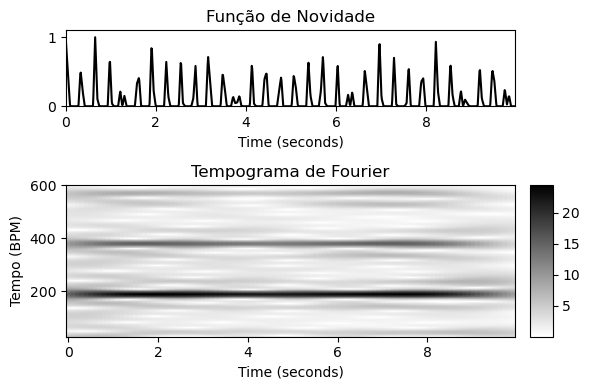

In [4]:
fn_wav = os.path.join( 'Audios', 'Luv(sic)_Part_3.mp3')
x, Fs = librosa.load(fn_wav)
x = x[:Fs*10]

nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs, N=4096, H=1024, gamma=100, M=10,norm=True)
nov, Fs_nov = libfmp.c6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

N = 500
H = 10
Theta = np.arange(30, 601)
X, T_coef, F_coef_BPM = compute_tempogram_fourier(nov, Fs_nov, N=N, H=H, Theta=Theta)
tempogram = np.abs(X)

fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.05], 'height_ratios': [1, 2]}, figsize=(6,4))        
libfmp.b.plot_signal(nov, Fs_nov, ax=ax[0,0], color='k', title='Função de Novidade')
ax[0,1].set_axis_off()
libfmp.b.plot_matrix(tempogram, T_coef=T_coef, F_coef=F_coef_BPM, ax=[ax[1,0], ax[1,1]], title='Tempograma de Fourier', ylabel='Tempo (BPM)', colorbar=True,figsize=(6,4));
plt.tight_layout()

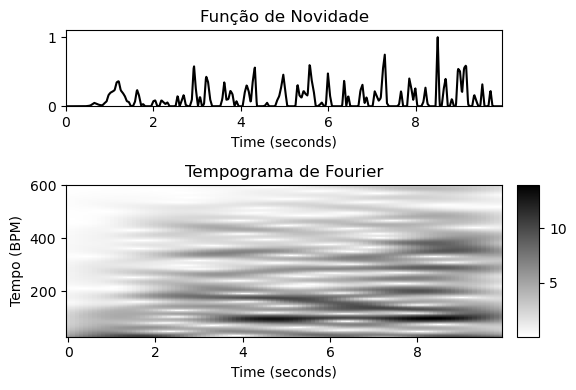

In [5]:
fn_wav = os.path.join( 'Audios', 'Friends_Yuki_Hayashi.wav')
x, Fs = librosa.load(fn_wav)
x = x[:Fs*10]

nov, Fs_nov = libfmp.c6.compute_novelty_energy(x, Fs=Fs, N=4096, H=1024, gamma=1, norm=True)
nov, Fs_nov = libfmp.c6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

N = 500
H = 10
Theta = np.arange(30, 601)
X, T_coef, F_coef_BPM = compute_tempogram_fourier(nov, Fs_nov, N=N, H=H, Theta=Theta)
tempogram = np.abs(X)

fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.05], 'height_ratios': [1, 2]}, figsize=(6,4))        
libfmp.b.plot_signal(nov, Fs_nov, ax=ax[0,0], color='k', title='Função de Novidade')
ax[0,1].set_axis_off()
libfmp.b.plot_matrix(tempogram, T_coef=T_coef, F_coef=F_coef_BPM, ax=[ax[1,0], ax[1,1]], title='Tempograma de Fourier', ylabel='Tempo (BPM)', colorbar=True, figsize=(6,4));
plt.tight_layout()

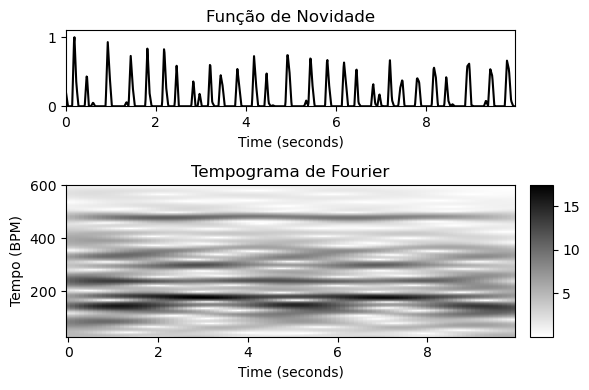

In [6]:
fn_wav = os.path.join( 'Audios', 'Friends_Yuki_Hayashi.wav')
x, Fs = librosa.load(fn_wav)
x = x[Fs * 25:Fs * 35]

nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs, N=4096, H=1024, gamma=100, M=10, norm=True)
nov, Fs_nov = libfmp.c6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

N = 500
H = 10
Theta = np.arange(30, 601)
X, T_coef, F_coef_BPM = compute_tempogram_fourier(nov, Fs_nov, N=N, H=H, Theta=Theta)
tempogram = np.abs(X)

fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.05], 'height_ratios': [1, 2]}, figsize=(6,4))        
libfmp.b.plot_signal(nov, Fs_nov, ax=ax[0,0], color='k', title='Função de Novidade')
ax[0,1].set_axis_off()
libfmp.b.plot_matrix(tempogram, T_coef=T_coef, F_coef=F_coef_BPM, ax=[ax[1,0], ax[1,1]], title='Tempograma de Fourier', ylabel='Tempo (BPM)', colorbar=True,figsize=(6,4));
plt.tight_layout()


# Tempograma de Autocorrelação

### autocorrelação

Em termos gerais, a autocorrelação é uma ferramenta matemática para medir a semelhança de um sinal com uma versão deslocada no tempo de si mesma. Seja $x: \mathbb{Z} \rightarrow \mathbb{R}$ um sinal discreto no tempo com energia finita. A autocorrelação $R_{xx}: \mathbb{Z} \rightarrow \mathbb{R}$ do sinal real $x$ é definida por:

$$R_{xx}(\ell) = \sum_{m \in \mathbb{Z}} x(m) x(m - \ell)$$

o que produz uma função que depende do parâmetro de deslocamento temporal ou defasagem $\ell \in \mathbb{Z}$. A autocorrelação $R_{xx}(\ell)$ é máxima para $\ell = 0$ e simétrica em relação a $\ell$. Intuitivamente, se a autocorrelação é grande para um determinado deslocamento, então o sinal contém padrões repetidos que estão separados por um período de tempo especificado pelo parâmetro de defasagem.

No exemplo a seguir, consideramos um sinal que consiste em dois padrões de clique: um com período 9 e outro com período 14. A autocorrelação tem trivialmente um pico no deslocamento $\ell = 0$ (o sinal é semelhante a si mesmo), depois em $\ell = 9$ (primeiro período), $\ell = 14$ (segundo período), $\ell = 18$ (duas vezes o primeiro período), $\ell = 27$ (três vezes o primeiro e, em $\ell = 28$, duas vezes o segundo período), e assim por diante. Em particular, se a autocorrelação tem um pico no deslocamento $\ell$, então ela também tem picos em inteiros.

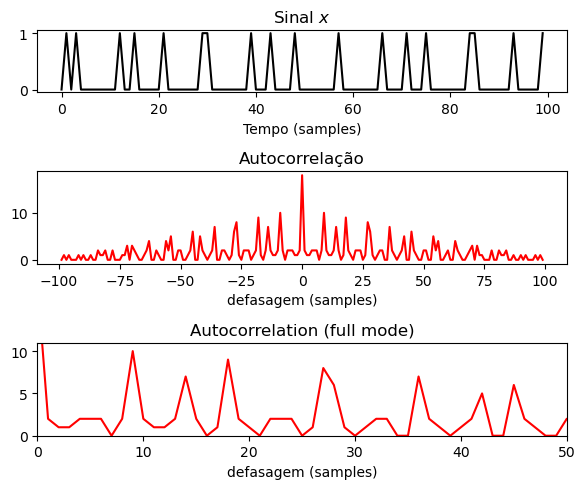

In [7]:
N = 100
x = np.zeros(N)
x[np.arange(1,N,14)] = 1
x[np.arange(3,N,9)] = 1

fig, ax = plt.subplots(3, 1, gridspec_kw={'height_ratios': [1, 1.5, 1.5]}, figsize=(6, 5))       

ax[0].plot(x, 'k')
ax[0].set_title('Sinal $x$')
ax[0].set_xlabel('Tempo (samples)')

r_xx = np.correlate(x, x, mode='full')
lag_axis = np.arange(-(N-1),N)
ax[1].plot(lag_axis,r_xx, 'r')
ax[1].set_title('Autocorrelação')
ax[1].set_xlabel(r'defasagem (samples)')

r_xx = np.correlate(x, x, mode='full')
lag_axis = np.arange(-(N-1),N)
ax[2].plot(lag_axis,r_xx, 'r')
ax[2].set_title('Autocorrelation (full mode)')
ax[2].set_xlabel(r'defasagem (samples)')
ax[2].set_xlim([0,50])
ax[2].set_ylim([0,11])

plt.tight_layout()

### Autocorrelação de curto prazo

Agora aplicamos a autocorrelação de forma local para analisar uma função de novidade dada $\Delta: \mathbb{Z} \rightarrow \mathbb{R}$ nas proximidades de um parâmetro de tempo $n$ dado. Para isso, fixamos uma função de janela $w: \mathbb{Z} \rightarrow \mathbb{R}$. A versão com janela $\Delta_{w,n}: \mathbb{Z} \rightarrow \mathbb{R}$ localizada no ponto $n \in \mathbb{Z}$ é definida por:

$$\Delta_{w,n}(m) := \Delta(m) \cdot w(m - n)$$

onde $m \in \mathbb{Z}$. Para obter a autocorrelação de curto prazo $A: \mathbb{Z} \times \mathbb{Z} \rightarrow \mathbb{R}$, calculamos a autocorrelação de $\Delta_{w,n}$:

$$A(n, \ell) := \sum_{m \in \mathbb{Z}} \Delta(m) \cdot w(m - n) \cdot \Delta(m - \ell) \cdot w(m - n - \ell)$$

Aqui, assumimos que a função de janela $w: [0: N-1] \rightarrow \mathbb{R}$ tem comprimento finito $N \in \mathbb{N}$. (Como de costume, por conveniência matemática, pode-se estender $w$ por zero fora do intervalo $[0: N-1]$.) Então, a autocorrelação da função de novidade localizada é zero para todos os parâmetros de defasagem temporais exceto para um número finito. Mais precisamente, pode-se mostrar que $A(n, \ell) = 0$ para $|\ell| > N$. Devido a essa propriedade e à simetria da autocorrelação, só precisamos considerar os parâmetros de defasagem temporal $\ell \in [0: N-1]$. Além disso, devido à janelamento, no máximo $N-\ell$ dos termos da soma são diferentes de zero. Para equilibrar o efeito do janelamento, o valor $A(n, \ell)$ pode ser dividido por um fator que depende das propriedades da janela e da sobreposição $N-\ell$ da janela e sua versão deslocada no tempo. Visualizar a autocorrelação de curto prazo $A$ leva a uma representação de tempo-defasagem com um parâmetro de quadro $n \in \mathbb{Z}$ e um parâmetro de defasagem $\ell \in [0: N-1]$.

### Implementação:
Assume-se que a curva de novidade $\Delta$ tem comprimento $L \in \mathbb{N}$ com uma taxa de amostragem $F_{\Delta s}$. Como função de janela $w$, escolhemos uma janela retangular de comprimento $N \in \mathbb{N}$. Além disso, introduzimos um parâmetro de tamanho de salto $H \in \mathbb{N}$. Usamos uma visualização centralizada, onde a função de novidade é preenchida com zeros pela metade do comprimento da janela. Como resultado, o primeiro quadro de $A$ indexado por $n = 0$ corresponde à posição temporal física $t = 0$ segundos. Além disso, o parâmetro de tamanho de salto $H$ reduz a taxa de quadros do tempograma para $F_{\Delta s} / H4. O algoritmo percorre os índices de quadros $n$ e calcula $A(n, \ell)$ para todos $\ell \in [0: N-1]$ usando uma única autocorrelação.

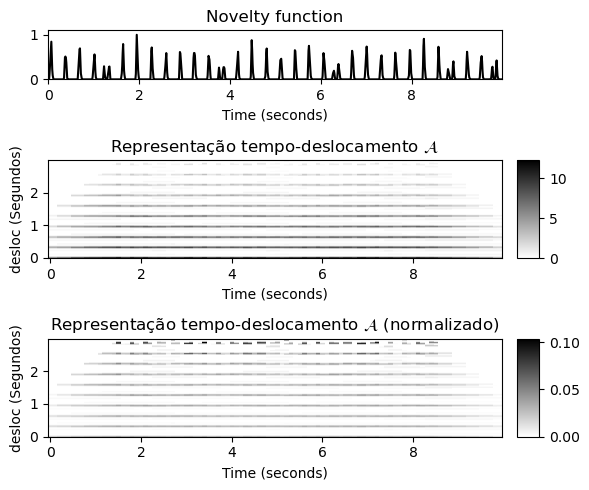

In [8]:
def compute_autocorrelation_local(x, Fs, N, H, norm_sum=True):
    """ Calcula a autocorrelação local
    Args:
        x (np.ndarray): Sinal de entrada
        Fs (scalar): Taxa de amostragem
        N (int): Comprimento da janela
        H (int): Tamanho do passo (hop size)
        norm_sum (bool): Normaliza pelo número de parcelas na autocorrelação local (Valor padrão = True)
    Retorna:
        A (np.ndarray): Representação do atraso temporal
        T_coef (np.ndarray): Eixo temporal (segundos)
        F_coef_lag (np.ndarray): Eixo de atraso """
    # Calcula o tamanho do padding à esquerda e à direita
    L_left = round(N / 2)
    L_right = L_left
    # Adiciona zero-padding ao sinal
    x_pad = np.concatenate((np.zeros(L_left), x, np.zeros(L_right)))
    L_pad = len(x_pad)
    # Calcula o número de segmentos que serão extraídos do sinal "padded"
    M = int(np.floor(L_pad - N) / H) + 1
    # Inicializa a matriz para armazenar os resultados da autocorrelação local
    A = np.zeros((N, M))
    # Define a janela utilizada na análise (neste caso, uma janela retangular)
    win = np.ones(N)
    # Calcula o vetor de soma de parcelas de atraso, se a normalização for ativada
    if norm_sum is True:
        lag_summand_num = np.arange(N, 0, -1)
    
    # Loop sobre cada segmento do sinal
    for n in range(M):
        t_0 = n * H
        t_1 = t_0 + N
        # Extrai o segmento local do sinal
        x_local = win * x_pad[t_0:t_1]
        # Calcula a autocorrelação local utilizando a função np.correlate
        r_xx = np.correlate(x_local, x_local, mode='full')
        r_xx = r_xx[N-1:]  # Mantém apenas a parte relevante do resultado da correlação
        # Normaliza a autocorrelação local pelo número de parcelas, se necessário
        if norm_sum is True:
            r_xx = r_xx / lag_summand_num
        # Armazena o resultado na matriz de autocorrelação local
        A[:, n] = r_xx
    
    # Calcula a taxa de amostragem do eixo temporal da autocorrelação local
    Fs_A = Fs / H
    # Cria o eixo temporal em segundos
    T_coef = np.arange(A.shape[1]) / Fs_A
    # Cria o eixo de atraso, representado em unidades de tempo
    F_coef_lag = np.arange(N) / Fs
    
    return A, T_coef, F_coef_lag

fn_wav = os.path.join( 'Audios', 'Luv(sic)_Part_3.mp3')
x, Fs = librosa.load(fn_wav)
x = x[:Fs*10]

nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs, N=2048, H=512, gamma=100, M=10, norm=1)
nov, Fs_nov = libfmp.c6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

N = 300
H = 10
A, T_coef, F_coef_lag = compute_autocorrelation_local(nov, Fs_nov, N, H, norm_sum=False)
A_norm, T_coef, F_coef_lag = compute_autocorrelation_local(nov, Fs_nov, N, H)

fig, ax = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 0.05], 'height_ratios': [1, 2, 2]}, figsize=(6,5))        

libfmp.b.plot_signal(nov, Fs_nov, ax=ax[0,0], color='k', title='Novelty function')
ax[0,1].set_axis_off()

libfmp.b.plot_matrix(A, ax=[ax[1,0], ax[1,1]], T_coef=T_coef, F_coef=F_coef_lag, title=r'Representação tempo-deslocamento $\mathcal{A}$', ylabel='desloc (Segundos)', colorbar=True);
libfmp.b.plot_matrix(A_norm, ax=[ax[2,0], ax[2,1]], T_coef=T_coef, F_coef=F_coef_lag, title=r'Representação tempo-deslocamento $\mathcal{A}$ (normalizado)', ylabel='desloc (Segundos)', colorbar=True);
plt.tight_layout()

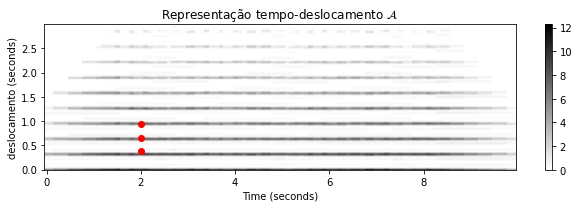

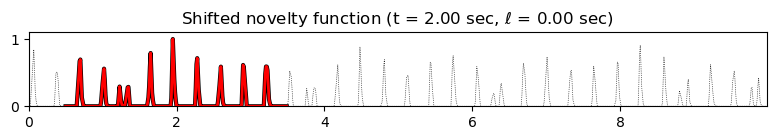

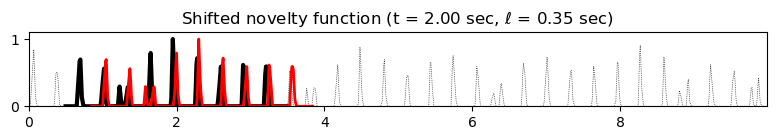

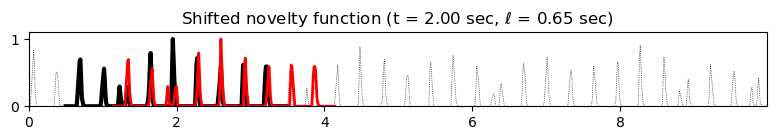

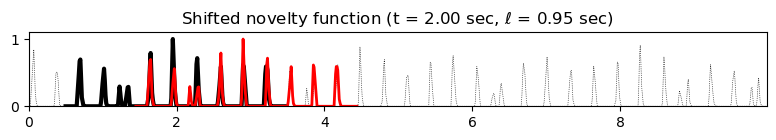

In [9]:
def plot_signal_local_lag(x, t_x, local_lag, t_local_lag, lag, xlim=None, figsize=(8, 1.5), title=''):
    """ Visualiza o sinal e o atraso local
    Args:
        x: Sinal
        t_x: Eixo temporal de x (dado em segundos)
        local_lag: Atraso local
        t_local_lag: Eixo temporal do atraso local (dado em segundos)
        lag: Atraso (dado em segundos)
        xlim: Limites para o eixo x (Valor padrão = None)
        figsize: Tamanho da figura (Valor padrão = (8, 1.5))
        title: Título da figura (Valor padrão = '')
    Returns:
        fig: Handle da figura Matplotlib """
    if xlim is None:
        xlim = [t_x[0], t_x[-1]]
    fig = plt.figure(figsize=figsize)
    # Plota o sinal com linha tracejada
    plt.plot(t_x, x, 'k:', linewidth=0.5)
    # Plota o atraso local
    plt.plot(t_local_lag, local_lag, 'k', linewidth=3.0)
    # Plota o atraso local deslocado
    plt.plot(t_local_lag+lag, local_lag, 'r', linewidth=2)
    plt.title(title)
    # Define os limites do eixo y
    plt.ylim([0, 1.1 * np.max(x)])
    # Define os limites do eixo x
    plt.xlim(xlim)
    plt.tight_layout()
    return fig

time_sec = np.array([2, 2, 2])
lag_sec = np.array([0.38, 0.65, 0.95])
coef_n = (time_sec * Fs_nov/H).astype(int)
coef_k = (lag_sec * Fs_nov).astype(int)

fig, ax, im = libfmp.b.plot_matrix(A, T_coef=T_coef, F_coef=F_coef_lag, figsize=(9,3), title=r'Representação tempo-deslocamento $\mathcal{A}$', ylabel='deslocamento (seconds)', colorbar=True);
ax[0].plot(T_coef[coef_n], F_coef_lag[coef_k],'ro')

L = len(nov)
L_left = round(N/2)
L_right = L_left
nov_pad = np.concatenate( ( np.zeros(L_left), nov, np.zeros(L_right) ) )
L_pad = len(nov_pad)
win = np.ones(N)

time_sec = np.array([2, 2, 2, 2])
lag_sec = np.array([0, 0.35, 0.65, 0.95])
t_nov = np.arange(nov.shape[0])/Fs_nov

for i in range(len(time_sec)):
    t_0 = time_sec[i] * Fs_nov
    t_1 = t_0 + N
    nov_local = win*nov_pad[t_0:t_1]
    t_nov_local = (np.arange(t_0,t_1) - L_left)/Fs_nov
    lag = lag_sec[i]
    title=r'Shifted novelty function (t = %0.2f sec, $\ell$ = %0.2f sec)'%(time_sec[i], lag)
    fig = plot_signal_local_lag(nov, t_nov, nov_local, t_nov_local, lag, title=title)

### Tempograma de autocorrelação

Para obter uma representação tempo-batida a partir da representação tempo-defasagem, é necessário converter o parâmetro de defasagem em um parâmetro de tempo. Para isso, é necessário conhecer a taxa de quadros ou a resolução temporal da função de novidade. Suponha que cada quadro de tempo corresponda a $r$ segundos, então um atraso de tempo $\ell$ (dado em quadros) corresponde a $\ell \cdot r$ segundos. Uma vez que um deslocamento de $\ell \cdot r$ segundos corresponde a uma taxa de $\frac{1}{\ell \cdot r}$ Hz, obtemos o tempo em BPM pela fórmula:

$$\tau = \frac{60}{r \cdot \ell} \quad \text{BPM}$$

Como exemplo, vamos supor que a taxa de características da função de novidade $\Delta$ seja $F_{\Delta s} = 100$ Hz e $r = 0.01$ segundos. Neste caso, o parâmetro de defasagem $\ell = 10$ corresponde a $600$ BPM e $\ell = 200$ corresponde a $30$ BPM. Para obter valores de tempo em uma faixa significativa, é comum usar um parâmetro de defasagem máximo $\ell_{\text{max}}$ para especificar o tempo mínimo e um parâmetro de defasagem mínimo $\ell_{\text{min}}$ para especificar o tempo máximo. Note que ao usar um comprimento de janela $N$, é necessário que:

$$ 1 \leq \ell_{\text{min}} \leq \ell_{\text{max}} \leq N - 1 $$

Com base na conversão de defasagem para BPM, o eixo de defasagem pode ser interpretado como um eixo de tempo. Isso nos permite definir o tempograma de autocorrelação $T_A$ definindo:

$$ T_A(n, \tau) := A(n, \ell)$$

para cada tempo $\tau = \frac{60}{r \cdot \ell}$ com $\ell \in [\ell_{\text{min}} : \ell_{\text{max}}]$. Neste caso, como os valores de tempo são recíprocos aos valores de defasagem amostrados linearmente, o eixo de tempo é amostrado de maneira não linear. Para obter um tempograma $T_A: \mathbb{Z} \times \Theta \rightarrow \mathbb{R} \geq 0$ definido no mesmo conjunto de tempos $\Theta$ que o tempograma de Fourier $T_F$, pode-se utilizar técnicas padrão de reamostragem e interpolação aplicadas ao domínio de tempos.

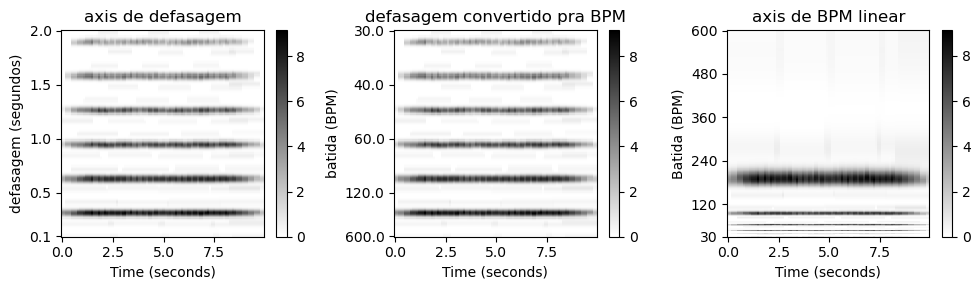

In [10]:
#@jit(nopython=True)
def compute_tempogram_autocorr(x, Fs, N, H, norm_sum=False, Theta=np.arange(30, 601)):
    """ Calcula o tempograma baseado em autocorrelação
    Args:
        x (np.ndarray): Sinal de entrada
        Fs (scalar): Taxa de amostragem
        N (int): Comprimento da janela
        H (int): Tamanho do passo (hop size)
        norm_sum (bool): Normaliza pelo número de parcelas na autocorrelação local (Valor padrão = False)
        Theta (np.ndarray): Conjunto de tempos (dados em BPM) (Valor padrão = np.arange(30, 601))
    Retorna:
        tempogram (np.ndarray): Tempograma
        T_coef (np.ndarray): Eixo temporal T_coef (segundos)
        F_coef_BPM (np.ndarray): Eixo de tempo F_coef_BPM (BPM)
        A_cut (np.ndarray): Representação do atraso temporal A_cut (cortado de acordo com Theta)
        F_coef_lag_cut (np.ndarray): Eixo de atraso F_coef_lag_cut """
    # Calcula os limites de tempo e atraso com base em Theta
    tempo_min = Theta[0]
    tempo_max = Theta[-1]
    lag_min = int(np.ceil(Fs * 60 / tempo_max))
    lag_max = int(np.ceil(Fs * 60 / tempo_min))
    
    # Calcula a autocorrelação local
    A, T_coef, F_coef_lag = compute_autocorrelation_local(x, Fs, N, H, norm_sum=norm_sum)
    
    # Corta a matriz A de acordo com os limites de atraso calculados
    A_cut = A[lag_min:lag_max+1, :]
    F_coef_lag_cut = F_coef_lag[lag_min:lag_max+1]
    
    # Calcula o eixo de BPM (batimentos por minuto) correspondente aos atrasos cortados
    F_coef_BPM_cut = 60 / F_coef_lag_cut
    
    # Interpola os resultados para obter o tempograma final
    tempogram = interp1d(F_coef_BPM_cut, A_cut, kind='linear',
                         axis=0, fill_value='extrapolate')(Theta)
    
    return tempogram, T_coef, Theta, A_cut, F_coef_lag_cut

Theta = np.arange(30, 601)
tempogram, T_coef, F_coef, A, F_coef_lag = compute_tempogram_autocorr(nov, Fs_nov, N, H, norm_sum=False, Theta=Theta)

fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 1, 1]}, figsize=(10,3)) 

libfmp.b.plot_matrix(A, T_coef=T_coef, F_coef=F_coef_lag, ax=[ax[0]], title='axis de defasagem', ylabel='defasagem (segundos)', colorbar=True);
lag_yticks = np.array([F_coef_lag[0], 0.5, 1.0, 1.5, F_coef_lag[-1]])
ax[0].set_yticks(lag_yticks)

libfmp.b.plot_matrix(A, T_coef=T_coef, F_coef=F_coef_lag, ax=[ax[1]],title='defasagem convertido pra BPM', ylabel='batida (BPM)', colorbar=True);
ax[1].set_yticks(lag_yticks)
ax[1].set_yticklabels(60/lag_yticks)

libfmp.b.plot_matrix(tempogram, T_coef=T_coef, F_coef=F_coef, ax=[ax[2]], title='axis de BPM linear', ylabel='Batida (BPM)', colorbar=True);
ax[2].set_yticks([F_coef[0], 120, 240, 360, 480, F_coef[-1]]);
plt.tight_layout()

### tempos harmônicos e sub-harmônicos

A seguir, ilustramos esses conceitos considerando uma trilha de cliques com aumento de tempo . Este exemplo ilustra que um tempograma de autocorrelação exibe sub-harmônicas de tempo, enquanto suprime harmônicas de tempo. A razão para esse comportamento é que uma alta correlação de uma seção local da função de novidade com a seção deslocada por $\ell$ amostras também implica uma alta correlação com uma seção deslocada por $k \cdot \ell$ defasagens para inteiros $k \in \mathbb{N}$. Supondo que $\ell$ corresponda ao tempo $\tau$, a defasagem $k \cdot \ell$ corresponde à sub-harmônica $\tau / k$. Note que esse comportamento contrasta com o tempograma de Fourier, que enfatiza as harmônicas de tempo, mas suprime as sub-harmônicas de tempo.

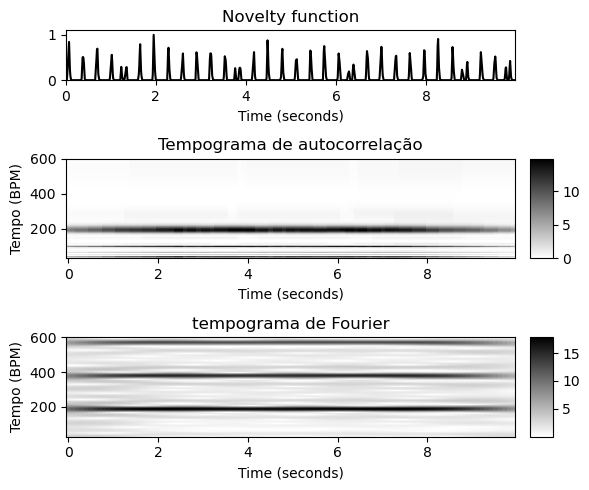

In [11]:
fn_wav = os.path.join( 'Audios', 'Luv(sic)_Part_3.mp3')
x, Fs = librosa.load(fn_wav)
x = x[:Fs*10]

nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs, N=2048, H=512, gamma=100, M=10, norm=1)
nov, Fs_nov = libfmp.c6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

N = 500
H = 10
Theta = np.arange(30, 601)
tempogram_A, T_coef, F_coef, A, F_coef_lag = compute_tempogram_autocorr(nov, Fs_nov, N, H, norm_sum=False, Theta=Theta)

fig, ax = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 0.05], 'height_ratios': [1, 2, 2]}, figsize=(6,5))        
libfmp.b.plot_signal(nov, Fs_nov, ax=ax[0,0], color='k', title='Novelty function')
ax[0,1].set_axis_off()
libfmp.b.plot_matrix(tempogram_A, T_coef=T_coef, F_coef=F_coef, ax=[ax[1,0], ax[1,1]], title='Tempograma de autocorrelação', ylabel='Tempo (BPM)', colorbar=True,figsize=(6,5));


X, T_coef, F_coef_BPM = libfmp.c6.compute_tempogram_fourier(nov, Fs_nov, N=N, H=H, Theta=Theta)
tempogram_F = np.abs(X)

libfmp.b.plot_matrix(tempogram_F, T_coef=T_coef, F_coef=F_coef_BPM, ax=[ax[2,0], ax[2,1]],  title='tempograma de Fourier', ylabel='Tempo (BPM)', colorbar=True,figsize=(6,5))
plt.tight_layout()

# Tempograma Cíclico

### Definição (Caso Contínuo)

Os vários níveis de pulso podem ser vistos em analogia à existência de harmônicos no contexto do tom. Para reduzir os efeitos dos harmônicos, introduzimos o conceito de **cromagrama**, inspiradas na ideia de **tempogramas cíclicos**. A ideia é formar classes de equivalência de tempo identificando tempos que diferem por uma potência de dois. Mais precisamente, dizemos que dois tempos $\tau_1$ e $\tau_2$ são **equivalentes em oitavas** se eles estiverem relacionados por $\tau_1 = 2^k \tau_2$ para algum $k \in \mathbb{Z}$. Para um parâmetro de tempo $\tau$, denotamos a resultante classe de equivalência de tempo por $[\tau]$. Por exemplo, para $\tau = 120$, obtém-se $[\tau] = \{... 30, 60, 120, 240, 480...\}$. Dada uma representação de tempograma $\mathcal{T}: \mathbb{Z} \times \mathbb{R}_{>0} \rightarrow \mathbb{R}_{\geq0}$, definimos o **tempograma cíclico** por

$$ C(n, [\tau]) := \sum_{\lambda \in [\tau]} \mathcal{T}(n, \lambda) $$

Note que as classes de equivalência de tempo correspondem topologicamente a um círculo. Fixando um tempo de referência $\tau_0$, o tempograma cíclico pode ser representado por uma função de mapeamento $C_{\tau_0} : \mathbb{Z} \times \mathbb{R}_{>0} \rightarrow \mathbb{R}_{\geq0}$ definida por

$$ C_{\tau_0}(n, s) := C(n, [s \cdot \tau_0]) $$

para $n \in \mathbb{Z}$ e um parâmetro de escala $s \in \mathbb{R}_{>0}$. Note que

$$ C_{\tau_0}(n, s) = C_{\tau_0}(n, 2^k s) $$

para $k \in \mathbb{Z}$. Em particular, $C_{\tau_0}$ é completamente determinado por seus valores $s \in [1, 2)$.

### Definição (Caso Discreto)

Até agora, assumimos que o espaço de parâmetros de tempo é contínuo. Na prática, pode-se calcular um tempograma cíclico $C_{\tau_0}$ apenas para um número finito de parâmetros $s \in [1, 2)$. Para calcular um valor $C_{\tau_0}(n, s)$, precisa-se somar os valores $\mathcal{T}(n, \tau)$ para os parâmetros de tempo $\tau \in \{s \cdot \tau_0 \cdot 2^k | k \in \mathbb{Z}\}$. Em outras palavras, os valores de tempo necessários são espaçados exponencialmente no eixo do tempo. Portanto, assim como para as features cromáticas, onde se usa um eixo de frequência logarítmica, requer-se um **eixo de tempo logarítmico** para calcular um tempograma cíclico. Para este fim, o intervalo de tempo é amostrado de maneira logarítmica de forma que cada oitava de tempo contenha $M$ **bins de tempo** para um dado número $M \in \mathbb{N}$. Então, obtém-se um **tempograma cíclico discreto** $C_n$ simplesmente somando os valores correspondentes das diferentes oitavas como antes. Isso gera um vetor de features de dimensão $M$ para cada quadro temporal $n \in \mathbb{Z}$, onde o eixo do tempo cíclico é amostrado em $M$ posições.


### Tempograma Cíclico de Fourier

Começando com uma representação de tempograma, agora mostramos como implementar um tempograma cíclico. A seguir, começamos com um **tempograma de Fourier**. A versão cíclica é referida como **tempograma cíclico de Fourier** denotado por $C_{\tau_0}^{F}$. A seguir, usamos uma faixa de clique que aumenta de tempo (de 110 a 130 BPM) como exemplo.

Nós procedemos em três etapas:

- Primeiro, calculamos um tempograma de Fourier com um eixo de tempo linear correspondente a $\Theta = [30:600]$.
- Em seguida, convertemos o eixo de tempo linear em um eixo de tempo logarítmico. Nesta etapa, usamos um tempo de referência $\tau_0 = 30 \text{ BPM}$ e cobrimos quatro oitavas de tempo, cada uma contendo $M = 40$ bins de tempo.
- Finalmente, dobramos ciclicamente o eixo do tempo identificando oitavas de tempo. Isso resulta no tempograma cíclico de dimensão $M$.

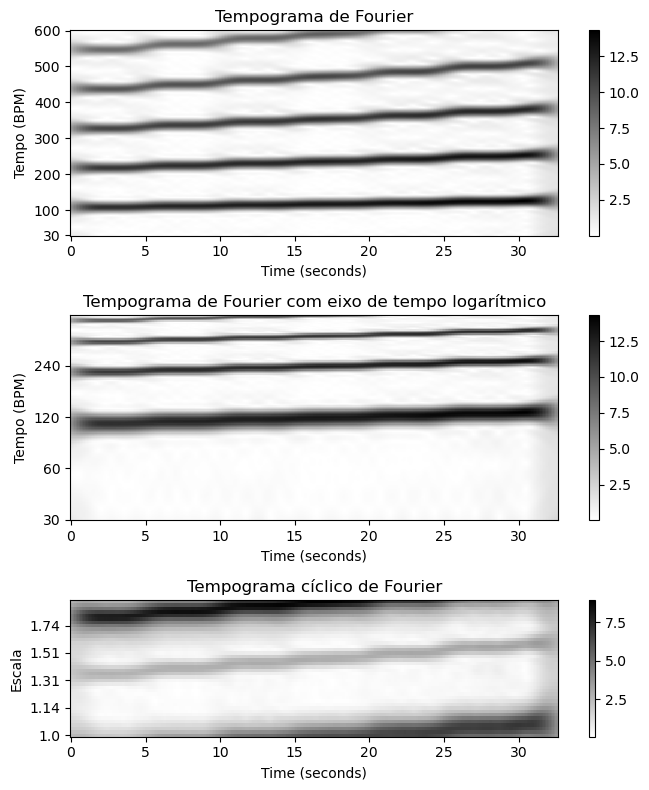

In [14]:
def compute_cyclic_tempogram(tempogram, F_coef_BPM, tempo_ref=30,
                             octave_bin=40, octave_num=4):
    """ Computa o tempograma cíclico.
    Args:
        tempogram (np.ndarray): Tempograma de entrada.
        F_coef_BPM (np.ndarray): Eixo de tempo em BPM.
        tempo_ref (float): Tempo de referência em BPM (valor padrão = 30).
        octave_bin (int): Número de bins por oitava de tempo (valor padrão = 40).
        octave_num (int): Número de oitavas de tempo a serem consideradas (valor padrão = 4).
    Returns:
        tempogram_cyclic (np.ndarray): Tempograma cíclico resultante.
        F_coef_scale (np.ndarray): Eixo de tempo em relação ao parâmetro de escala.
        tempogram_log (np.ndarray): Tempograma com eixo de tempo logarítmico.
        F_coef_BPM_log (np.ndarray): Eixo de tempo logarítmico em BPM. """
    # Calcula o eixo logarítmico de BPM com base no tempo de referência e nas oitavas
    F_coef_BPM_log = tempo_ref * np.power(2, np.arange(0, octave_num*octave_bin)/octave_bin)
    
    # Calcula o eixo de escala logarítmica
    F_coef_scale = np.power(2, np.arange(0, octave_bin)/octave_bin)
    
    # Interpola o tempograma para o eixo logarítmico de BPM
    tempogram_log = interp1d(F_coef_BPM, tempogram, kind='linear', axis=0, fill_value='extrapolate')(F_coef_BPM_log)
    
    # Calcula o número de valores no eixo logarítmico de BPM
    K = len(F_coef_BPM_log)
    
    # Inicializa o tempograma cíclico com zeros
    tempogram_cyclic = np.zeros((octave_bin, tempogram.shape[1]))
    
    # Calcula o tempograma cíclico, somando os valores das oitavas correspondentes
    for m in np.arange(octave_bin):
        tempogram_cyclic[m, :] = np.mean(tempogram_log[m:K:octave_bin, :], axis=0)
    
    # Retorna o tempograma cíclico, o eixo de escala, o tempograma logarítmico e o eixo logarítmico de BPM
    return tempogram_cyclic, F_coef_scale, tempogram_log, F_coef_BPM_log

def set_yticks_tempogram_cyclic(ax, octave_bin, F_coef_scale, num_tick=5):
    """ Define os yticks (marcadores no eixo y) com base no parâmetro de escala.
    Args:
        ax (mpl.axes.Axes): Eixo da figura.
        octave_bin (int): Número de bins por oitava de tempo.
        F_coef_scale (np.ndarray): Eixo de tempo em relação ao parâmetro de escala.
        num_tick (int): Número de yticks (valor padrão = 5). """
    # Define os valores de yticks distribuídos uniformemente ao longo da oitava
    yticks = np.arange(0, octave_bin, octave_bin // num_tick)
    
    # Aplica os yticks e seus rótulos ao eixo da figura
    ax.set_yticks(yticks)
    ax.set_yticklabels(F_coef_scale[yticks].astype((np.unicode_, 4)))

# Carrega o arquivo de áudio
fn_wav = os.path.join('Audios', 'Analise_temporal_1.mp3')
Fs = 22050
x, Fs = librosa.load(fn_wav) 

# Calcula o espectro de novidade (novelty spectrum) e o reamostra
nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs, N=2048, H=512, gamma=100, M=10, norm=True)
nov, Fs_nov = libfmp.c6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

# Calcula o tempograma de Fourier
X, T_coef, F_coef_BPM = compute_tempogram_fourier(nov, Fs_nov, N=500, H=10, Theta=np.arange(30, 601))
tempogram = np.abs(X)
tempo_ref = 30
octave_bin = 40
octave_num = 4

# Computa o tempograma cíclico
output = compute_cyclic_tempogram(tempogram, F_coef_BPM, tempo_ref=tempo_ref, octave_bin=octave_bin, octave_num=octave_num)
tempogram_cyclic = output[0]
F_coef_scale = output[1]
tempogram_log = output[2]
F_coef_BPM_log = output[3]

# Cria as figuras para visualização
fig, ax = plt.subplots(3, 1, gridspec_kw={'height_ratios': [1.5, 1.5, 1]}, figsize=(7, 8))       

# Tempograma de Fourier
im_fig, im_ax, im = libfmp.b.plot_matrix(tempogram, ax=[ax[0]],T_coef=T_coef, F_coef=F_coef_BPM, title='Tempograma de Fourier', 
                                         ylabel='Tempo (BPM)', colorbar=True);
ax[0].set_yticks([F_coef_BPM[0],100, 200, 300, 400, 500, F_coef_BPM[-1]]);

# Tempograma de Fourier com eixo de tempo logarítmico
im_fig, im_ax, im = libfmp.b.plot_matrix(tempogram_log, ax=[ax[1]], T_coef=T_coef, title='Tempograma de Fourier com eixo de tempo logarítmico', 
                                         ylabel='Tempo (BPM)', colorbar=True);
yticks = np.arange(octave_num) * octave_bin
ax[1].set_yticks(yticks)
ax[1].set_yticklabels(F_coef_BPM_log[yticks].astype(int));

# Tempograma cíclico de Fourier
im_fig, im_ax, im = libfmp.b.plot_matrix(tempogram_cyclic, ax=[ax[2]], T_coef=T_coef, title='Tempograma cíclico de Fourier', 
                                         ylabel='Escala', colorbar=True);
set_yticks_tempogram_cyclic(ax[2], octave_bin, F_coef_scale, num_tick=5)
plt.tight_layout()


### Tempograma Cíclico de Autocorrelação

De forma similar, começando com o **tempograma de autocorrelação**, a versão cíclica é referida como **tempograma cíclico de autocorrelação** denotado por $C_{\tau_0}^{A}$. Usando novamente o tempo de referência $\tau_0 = 30 \text{ BPM}$ e a faixa de cliques como exemplo, a figura a seguir mostra o tempograma de autocorrelação original, o tempograma com eixo de tempo logarítmico e o tempograma cíclico utilizando $M = 40$ bins de tempo por oitava.

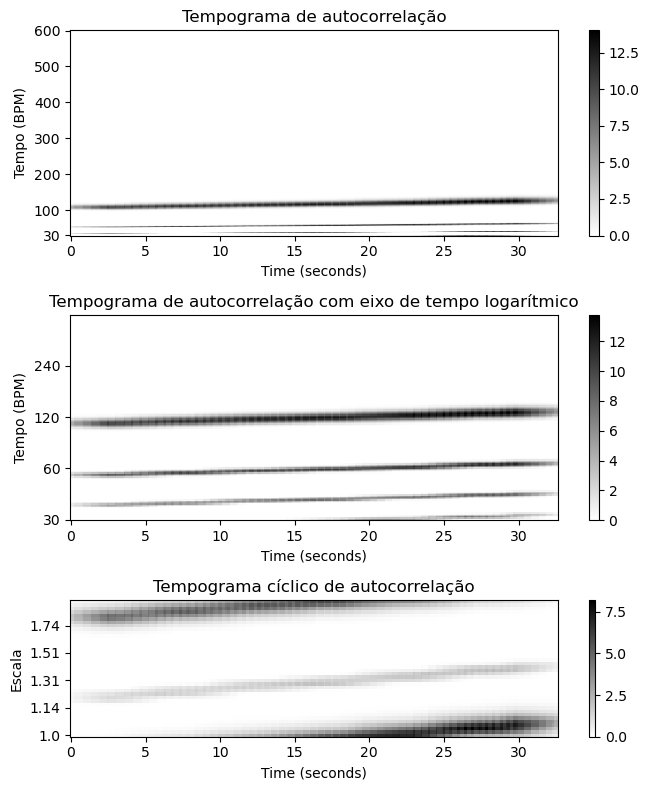

In [15]:
# Calcula o espectro de novidade (novelty spectrum) a partir do sinal de áudio 'x'
nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs, N=2048, H=512, 
                                                 gamma=100, M=10, norm=True)
# Reamostra o espectro de novidade para uma taxa de amostragem de 100 Hz
nov, Fs_nov = libfmp.c6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

# Define os parâmetros para o cálculo do tempograma de autocorrelação
N = 500 
H = 10
Theta = np.arange(30, 601)

# Calcula o tempograma de autocorrelação a partir do espectro de novidade
output = compute_tempogram_autocorr(nov, Fs_nov, N=N, H=H, 
                                              norm_sum=False, Theta=Theta)
tempogram = output[0]
T_coef = output[1]
F_coef_BPM = output[2]

# Define os parâmetros para o cálculo do tempograma cíclico
tempo_ref = 30
octave_bin = 40
octave_num = 4

# Calcula o tempograma cíclico com base no tempograma de autocorrelação
output = compute_cyclic_tempogram(tempogram, F_coef_BPM, tempo_ref=tempo_ref, 
                                  octave_bin=octave_bin, octave_num=octave_num)
tempogram_cyclic = output[0]
F_coef_scale = output[1]
tempogram_log = output[2]
F_coef_BPM_log = output[3]

# Cria subplots para exibir os diferentes tempogramas
fig, ax = plt.subplots(3, 1, gridspec_kw={'height_ratios': [1.5, 1.5, 1]}, figsize=(7, 8))       

# Tempograma de autocorrelação original
im_fig, im_ax, im = libfmp.b.plot_matrix(tempogram, ax=[ax[0]], T_coef=T_coef, 
                                         F_coef=F_coef_BPM, 
                                         figsize=(6,3), ylabel='Tempo (BPM)', colorbar=True,
                                         title='Tempograma de autocorrelação');
ax[0].set_yticks([Theta[0], 100, 200, 300, 400, 500, Theta[-1]]);

# Tempograma de autocorrelação com eixo de tempo logarítmico
im_fig, im_ax, im = libfmp.b.plot_matrix(tempogram_log, ax=[ax[1]], T_coef=T_coef, 
                                         figsize=(6,3), ylabel='Tempo (BPM)', colorbar=True,
                                         title='Tempograma de autocorrelação com eixo de tempo logarítmico');
yticks = np.arange(octave_num) * octave_bin
ax[1].set_yticks(yticks)
ax[1].set_yticklabels(F_coef_BPM_log[yticks].astype(int));

# Tempograma cíclico de autocorrelação
im_fig, im_ax, im = libfmp.b.plot_matrix(tempogram_cyclic, ax=[ax[2]], T_coef=T_coef, 
                                         figsize=(6,2), ylabel='Escala', colorbar=True,
                                         title='Tempograma cíclico de autocorrelação');
set_yticks_tempogram_cyclic(ax[2], octave_bin, F_coef_scale, num_tick=5)
plt.tight_layout()


### Harmônicos e Sub-harmônicos de Tempo

Como discutido anteriormente, o **tempograma de Fourier** enfatiza os harmônicos de tempo, enquanto o **tempograma de autocorrelação** enfatiza os sub-harmônicos de tempo. Essas propriedades, como ilustrado na figura a seguir, também são refletidas nas versões cíclicas dos tempogramas. No **tempograma cíclico de Fourier** da faixa de cliques, o **tempo dominante** é visível como uma linha fraca crescente começando com $s = 1.33$ no tempo $t = 0$; no **tempograma cíclico de autocorrelação**, o **subdominante de tempo** aparece como uma linha fraca crescente começando com $s = 1.2$ no tempo $t = 0$. Além disso, a próxima figura também mostra versões normalizadas por coluna, assim como versões utilizando uma resolução de tempo menor ($M = 15$ bins de tempo).

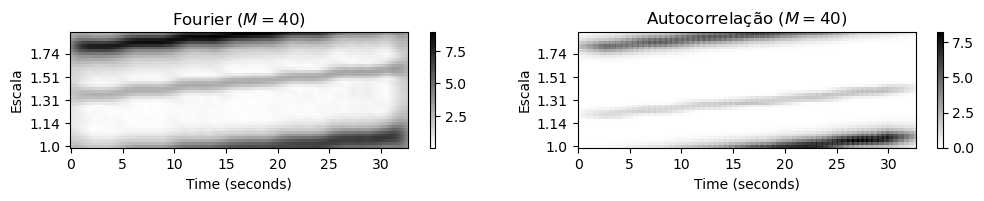

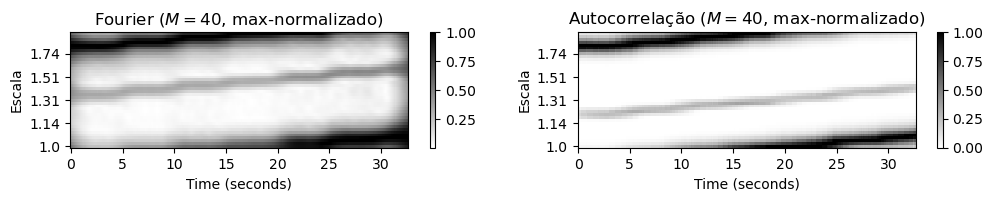

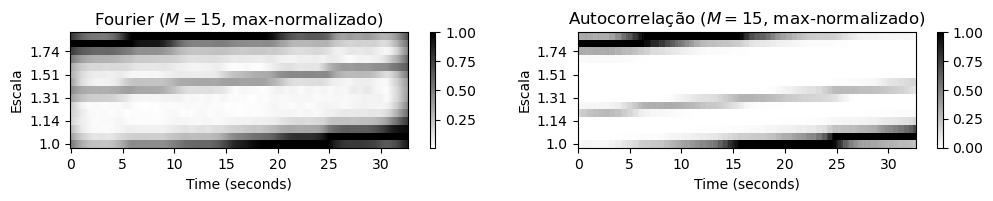

In [16]:
def plot_tempogram_Fourier_autocor(tempogram_F, tempogram_A, T_coef, F_coef_BPM, 
                                   octave_bin, title_F, title_A, norm=None):
    """ Visualiza o tempograma baseado em Fourier e o tempograma baseado em autocorrelação.
    Args:
        tempogram_F (np.ndarray): Tempograma baseado em Fourier.
        tempogram_A (np.ndarray): Tempograma baseado em autocorrelação.
        T_coef (np.ndarray): Eixo temporal.
        F_coef_BPM (np.ndarray): Eixo de tempo em BPM.
        octave_bin (int): Número de bins por oitava de tempo.
        title_F (str): Título do gráfico para o tempograma de Fourier.
        title_A (str): Título do gráfico para o tempograma de autocorrelação.
        norm (str, opcional): Tipo de normalização a ser aplicada ('max' para normalização pelo valor máximo). """
    # Cria subplots lado a lado com uma razão de largura 1:1
    fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(12, 1.5))       

    # Calcula o tempograma cíclico baseado em Fourier
    output = compute_cyclic_tempogram(tempogram_F, F_coef_BPM, octave_bin=octave_bin)
    tempogram_cyclic_F = output[0]
    F_coef_scale = output[1]
    
    # Aplica normalização se necessário
    if norm is not None:
        tempogram_cyclic_F = libfmp.c3.normalize_feature_sequence(tempogram_cyclic_F, norm=norm)
    # Plota o tempograma cíclico de Fourier
    libfmp.b.plot_matrix(tempogram_cyclic_F, T_coef=T_coef, ax=[ax[0]], title=title_F, ylabel='Escala', colorbar=True)
    set_yticks_tempogram_cyclic(ax[0], octave_bin, F_coef_scale, num_tick=5)

    # Calcula o tempograma cíclico baseado em autocorrelação
    output = compute_cyclic_tempogram(tempogram_A, F_coef_BPM, octave_bin=octave_bin)
    tempogram_cyclic_A  = output[0]
    F_coef_scale = output[1]
    
    # Aplica normalização se necessário
    if norm is not None:
        tempogram_cyclic_A = libfmp.c3.normalize_feature_sequence(tempogram_cyclic_A, norm=norm)
    # Plota o tempograma cíclico de autocorrelação
    libfmp.b.plot_matrix(tempogram_cyclic_A, T_coef=T_coef, ax=[ax[1]], title=title_A, ylabel='Escala', colorbar=True)
    set_yticks_tempogram_cyclic(ax[1], octave_bin, F_coef_scale, num_tick=5)

# Carrega o arquivo de áudio
fn_wav = os.path.join('Audios','Analise_temporal_1.mp3')
Fs = 22050
x, Fs = librosa.load(fn_wav)

# Calcula o espectro de novidade e o reamostra
nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs, N=2048, H=512, gamma=100, M=10, norm=True)
nov, Fs_nov = libfmp.c6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

# Define os parâmetros para o cálculo dos tempogramas
N = 500 
H = 10
Theta = np.arange(30, 601)

# Calcula o tempograma de Fourier a partir do espectro de novidade
X, T_coef, F_coef_BPM = libfmp.c6.compute_tempogram_fourier(nov, Fs_nov, N=N, H=H, Theta=Theta)
tempogram_F = np.abs(X)

# Calcula o tempograma de autocorrelação a partir do espectro de novidade
output = libfmp.c6.compute_tempogram_autocorr(nov, Fs_nov, N=N, H=H, Theta=Theta, norm_sum=False)
tempogram_A = output[0]

# Visualiza o tempograma cíclico de Fourier e de autocorrelação (sem normalização)
octave_bin = 40
title_F = r'Fourier ($M=%d$)' % octave_bin
title_A = r'Autocorrelação ($M=%d$)' % octave_bin
plot_tempogram_Fourier_autocor(tempogram_F, tempogram_A, T_coef, F_coef_BPM, octave_bin, title_F, title_A)

# Visualiza o tempograma cíclico de Fourier e de autocorrelação (normalizado pelo valor máximo)
octave_bin = 40
title_F = r'Fourier ($M=%d$, max-normalizado)' % octave_bin
title_A = r'Autocorrelação ($M=%d$, max-normalizado)' % octave_bin
plot_tempogram_Fourier_autocor(tempogram_F, tempogram_A, T_coef, F_coef_BPM, octave_bin, title_F, title_A, norm='max')

# Visualiza o tempograma cíclico de Fourier e de autocorrelação com menor resolução temporal (normalizado pelo valor máximo)
octave_bin = 15
title_F = r'Fourier ($M=%d$, max-normalizado)' % octave_bin
title_A = r'Autocorrelação ($M=%d$, max-normalizado)' % octave_bin
plot_tempogram_Fourier_autocor(tempogram_F, tempogram_A, T_coef, F_coef_BPM, octave_bin, title_F, title_A, norm='max')


### Features de Tempo

As representações de tempograma cíclico são as contrapartes baseadas em tempo das representações de cromagrama baseadas em harmonia. Comparadas aos tempogramas padrão, as versões cíclicas são mais robustas a ambiguidades causadas pelos vários níveis de pulso. Além disso, pode-se simular mudanças no tempo deslocando ciclicamente um tempograma cíclico. Note que isso é similar à propriedade dos cromagramas, que podem ser deslocados ciclicamente para simular modulações no tom. Como uma vantagem adicional, mesmo versões de baixa dimensão dos tempogramas cíclicos discretos ainda contêm informações locais valiosas sobre o tempo do sinal musical subjacente.

# pulso local predominante

A tarefa de rastreamento de batidas e pulsos pode ser vista como uma extensão da estimativa de tempo, no sentido de que, além da taxa, ela também considera a fase dos pulsos. A ideia do **Tempograma de Fourier** foi comparar localmente uma dada curva de novidade com sinusoides janeladas. Baseado nessa ideia, determinamos para cada posição temporal uma sinusoide janelada que melhor captura a estrutura de pico local da função de novidade. Em vez de observar as sinusoides janeladas individualmente, a ideia crucial é empregar uma técnica de soma acumulada dessas sinusoides ao longo do tempo. Como resultado, obtém-se uma única função que pode ser considerada como uma melhoria da periodicidade local da função de novidade original. Revelando informações sobre o **pulso local predominante** (PLP), essa representação é referida como uma **função PLP**. Nesse contexto, usamos o termo **pulso predominante** de maneira bastante livre para se referir ao nível de pulso mais forte que pode ser medido na função de novidade subjacente. Intuitivamente, a função PLP pode ser vista como um rastreador de pulsos que pode se ajustar a mudanças contínuas e repentinas no tempo, desde que a função de novidade subjacente possua padrões periodicamente localizados.

### Sinusoides Janeladas Ótimas

Dada uma função de novidade $\Delta : \mathbb{Z} \rightarrow \mathbb{R}$, derivamos o **Tempograma de Fourier** a partir do coeficiente de Fourier complexo $\mathcal{F}(n, \omega)$ definido por

$$ \mathcal{F}(n, \omega) = \sum_{m \in \mathbb{Z}} \Delta(m)\overline{w}(m-n)\exp(-2\pi i \omega m). $$

A partir disso, obtivemos o tempograma de Fourier ao definir

$$ \mathcal{T}^{F}(n, \tau) = |\mathcal{F}(n, \tau/60)|. $$

Para cada posição temporal $n \in \mathbb{Z}$, consideramos agora o parâmetro de tempo $\tau_n \in \Theta$ que maximiza $\mathcal{T}^{F}(n, \tau)$:

$$ \tau_n := \underset{\tau \in \Theta}{\text{argmax}} \ \mathcal{T}^{F}(n, \tau). $$

A **informação de fase** codificada pelo coeficiente de Fourier complexo $\mathcal{F}(n, \omega)$ pode ser usada para derivar a fase $\varphi_n$ da sinusoide janelada do tempo $\tau_n$ que melhor se correlaciona com a seção local em $n$ da função de novidade $\Delta$.Além disso, a fase é dada por

$$ \varphi_n = -\frac{1}{2\pi} \text{angle}(\mathcal{F}(n, \tau_n/60)), $$

onde o ângulo de um número complexo é dado em radianos (um número em $[0, 2\pi)$). Baseado em $\tau_n$ e $\varphi_n$, definimos a **sinusoide janelada ótima** $\kappa_n : \mathbb{Z} \rightarrow \mathbb{R}$ definindo

$$ \kappa_n(m) := w(m-n)\cos\left(2\pi\left(\frac{\tau_n}{60} \cdot m - \varphi_n\right)\right) $$

para cada ponto de tempo $n \in \mathbb{Z}$, onde usamos a mesma função de janela $w$ que para o tempograma de Fourier. Intuitivamente, a sinusoide $\kappa_n$ melhor explica a natureza periódica local da função de novidade no tempo $n$ com respeito ao parâmetro de tempo $\tau_n$. O período $60/\tau_n$ corresponde ao período predominante da função de novidade, e a informação de fase $\varphi_n$ cuida de ajustar a fase dos máximos de $\kappa_n$ e dos picos da função de novidade. A relevância das sinusoides $\kappa_n$ depende não apenas da qualidade da função de novidade, mas também da largura da janela $w$ e do conjunto de tempos $\Theta$.

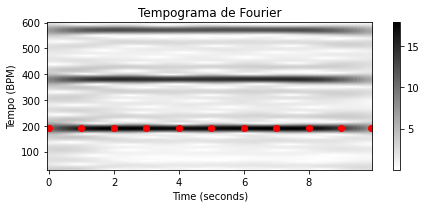

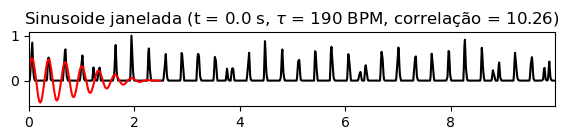

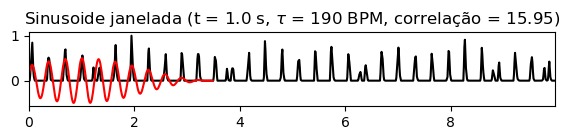

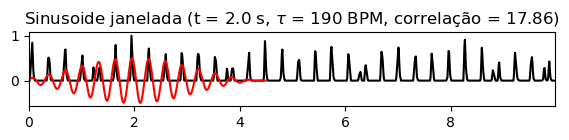

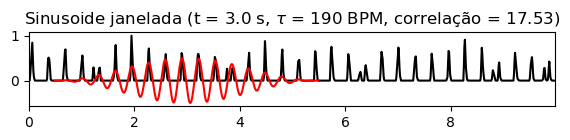

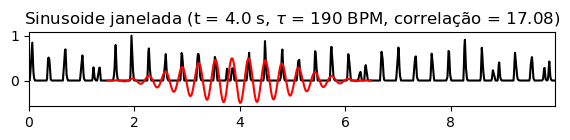

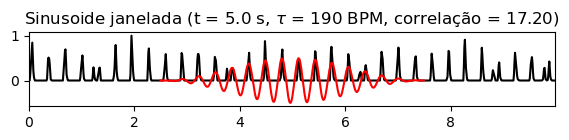

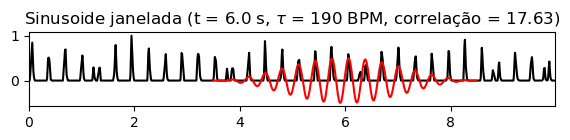

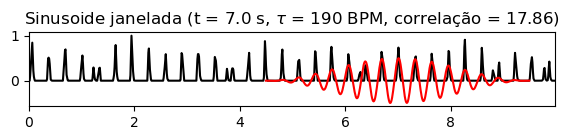

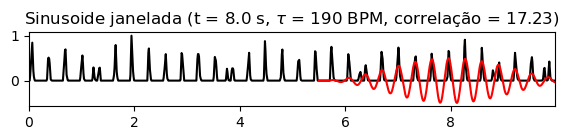

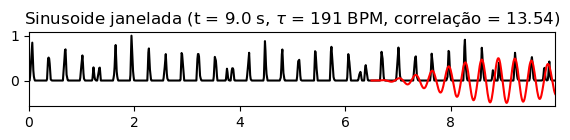

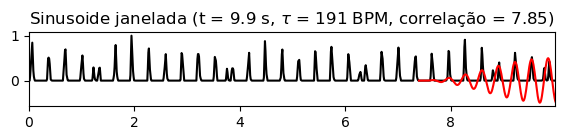

In [19]:
fn_wav = os.path.join('Audios', 'Luv(sic)_Part_3.mp3')
x, Fs = librosa.load(fn_wav)
x = x[:Fs*10]

nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs, N=2048, H=512, gamma=100, M=10, norm=True)
nov, Fs_nov = libfmp.c6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

# Define os parâmetros para o cálculo do tempograma de Fourier
N = 500  # Corresponde a 5 segundos (Fs_nov = 100 Hz)
H = 10   # Tamanho do salto que leva a uma resolução de tempograma de 10 Hz
Theta = np.arange(30, 601)  # Parâmetro de faixa de tempo (30 a 600 BPM)

# Calcula o tempograma de Fourier a partir do espectro de novidade
X, T_coef, F_coef_BPM = compute_tempogram_fourier(nov, Fs=Fs_nov, N=N, H=H, Theta=Theta)
tempogram = np.abs(X)

# Gera o eixo de tempo para o espectro de novidade
t_nov = np.arange(nov.shape[0]) / Fs_nov

# Define os índices de tempo específicos para análise
coef_n = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99])
coef_k = np.zeros(len(coef_n), dtype=int)

# Identifica o índice de maior correlação para cada índice de tempo
for i in range(len(coef_n)):
    coef_k[i] = np.argmax(tempogram[:, coef_n[i]])

# Plota o tempograma de Fourier com os pontos de maior correlação destacados
fig, ax, im = libfmp.b.plot_matrix(tempogram, T_coef=T_coef, F_coef=F_coef_BPM, figsize=(6.5, 3), ylabel='Tempo (BPM)',
                                   title='Tempograma de Fourier')
ax[0].plot(T_coef[coef_n], F_coef_BPM[coef_k], 'ro')

# Para cada ponto de maior correlação, gera e plota a sinusoide janelada ótima correspondente
for i in range(len(coef_n)):
    n = coef_n[i]
    k = coef_k[i]
    tempo = F_coef_BPM[k]
    time = T_coef[n]
    corr = np.abs(X[k, n])
    
    # Calcula a sinusoide janelada ótima
    kernel, t_kernel, t_kernel_sec = compute_sinusoid_optimal(X[k, n], F_coef_BPM[k], n, Fs_nov, N, H)
    
    # Define o título do gráfico com as informações da sinusoide
    title = r'Sinusoide janelada (t = %0.1f s, $\tau$ = %0.0f BPM, correlação = %0.2f)' % (time, tempo, corr)
    
    # Plota a sinusoide janelada ótima sobre o espectro de novidade
    libfmp.c6.plot_signal_kernel(nov, t_nov, 0.5 * kernel, t_kernel_sec, 
                                 figsize=(6, 1.5), title=title)


### Definição da Função PLP

A estimativa de sinusoides janeladas ótimas em regiões com uma estrutura de pico fortemente corrompida é problemática. E isso é particularmente verdadeiro no caso de janelas pequenas. Para tornar a estimativa de periodicidade mais robusta, mantendo a flexibilidade temporal, a ideia é formar uma única função em vez de analisar as sinusoides de forma individual. Para isso, aplicamos uma técnica de **sobreposição-acumulação** (*overlap-add*), onde as sinusoides janeladas ótimas $\kappa_n$ são acumuladas ao longo de todas as posições de tempo $n \in \mathbb{Z}$. Além disso, consideramos apenas a parte positiva da função resultante. Mais precisamente, definimos uma função $\Gamma : \mathbb{Z} \rightarrow \mathbb{R}_{\geq 0}$ como segue:

$$ \Gamma(m) = \left|\sum_{n \in \mathbb{Z}} \kappa_n(m)\right|_{\geq 0} $$

para $n \in \mathbb{Z}$, onde utilizamos a retificação de meia onda. A função resultante é nossa representação de nível médio referida como **função PLP** (indicando o pulso local predominante).

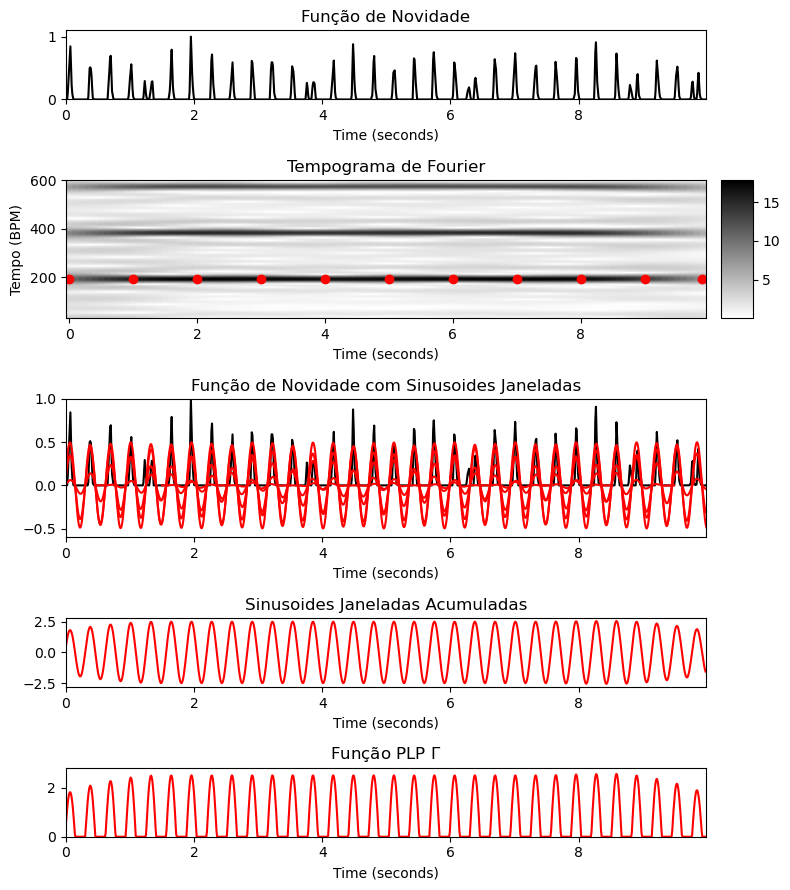

In [20]:
L = nov.shape[0]
N_left = N // 2
L_left = N_left
L_right = N_left
L_pad = L + L_left + L_right
t_pad = np.arange(L_pad)


t_nov = np.arange(nov.shape[0]) / Fs_nov

coef_n = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99])
coef_k = np.zeros(len(coef_n), dtype=int)

# Identifica o índice de maior correlação no tempograma para cada índice de tempo específico
for i in range(len(coef_n)):
    coef_k[i] = np.argmax(tempogram[:, coef_n[i]])

# Cria a figura com subplots organizados em uma grade de 5x2, com larguras e alturas ajustadas
fig, ax = plt.subplots(5, 2, gridspec_kw={'width_ratios': [1, 0.05], 'height_ratios': [1, 2, 2, 1, 1]}, figsize=(8, 9))        

# Plota a função de novidade
libfmp.b.plot_signal(nov, Fs_nov, ax=ax[0, 0], color='k', title='Função de Novidade')
ax[0, 1].set_axis_off()  # Desativa o eixo direito do subplot

# Plota o tempograma de Fourier e marca os pontos de maior correlação
libfmp.b.plot_matrix(tempogram, T_coef=T_coef, F_coef=F_coef_BPM, ax=[ax[1,0], ax[1,1]],title='Tempograma de Fourier',
                     ylabel='Tempo (BPM)', colorbar=True)
ax[1, 0].plot(T_coef[coef_n], F_coef_BPM[coef_k], 'ro')

# Plota a função de novidade junto com as sinusoides janeladas
libfmp.b.plot_signal(nov, Fs_nov, ax=ax[2, 0], color='k', title='Função de Novidade com Sinusoides Janeladas')
ax[2, 1].set_axis_off()  # Desativa o eixo direito do subplot

# Inicializa a função PLP acumulada com zeros
nov_PLP = np.zeros(L_pad)

# Sobrepõe e acumula as sinusoides janeladas na função PLP
for i in range(len(coef_n)):
    n = coef_n[i]
    k = coef_k[i]
    tempo = F_coef_BPM[k]
    time = T_coef[n]
    
    # Calcula a sinusoide janelada ótima
    kernel, t_kernel, t_kernel_sec = compute_sinusoid_optimal(X[k, n], F_coef_BPM[k], n, Fs_nov, N, H)    
    
    # Acumula a sinusoide janelada na função PLP
    nov_PLP[t_kernel] = nov_PLP[t_kernel] + kernel
    
    # Plota a sinusoide janelada sobre a função de novidade
    ax[2, 0].plot(t_kernel_sec, 0.5 * kernel, 'r')
    ax[2, 0].set_ylim([-0.6, 1])
    
# Remove o preenchimento com zeros para obter a função PLP final
nov_PLP = nov_PLP[L_left:L_pad-L_right]

# Plota a função PLP acumulada (antes da retificação)
libfmp.b.plot_signal(nov_PLP, Fs_nov, ax=ax[3, 0], color='r', title='Sinusoides Janeladas Acumuladas')
ax[3,1].set_axis_off()  # Desativa o eixo direito do subplot

# Aplica a retificação de meia onda à função PLP (elimina valores negativos)
nov_PLP[nov_PLP < 0] = 0

# Plota a função PLP final ($\Gamma$) após a retificação
libfmp.b.plot_signal(nov_PLP, Fs_nov, ax=ax[4, 0], color='r', title='Função PLP $\Gamma$')
ax[4, 1].set_axis_off()  # Desativa o eixo direito do subplot

# Ajusta o layout dos subplots para evitar sobreposição de elementos
plt.tight_layout()


Observe como os máximos das diferentes sinusoides janeladas se alinham não apenas com os picos da função de novidade, mas também com os máximos das sinusoides vizinhas nas regiões de sobreposição, o que leva a **interferências construtivas**. Os valores de tempo que maximizam, assim como as sinusoides janeladas ótimas correspondentes, são indicados para sete posições diferentes. Note que cada uma dessas sinusoides janeladas tenta explicar a natureza periodicamente local da estrutura de pico da função de novidade, onde pequenas variações da periodicidade "ideal" e picos fracos são balanceados. Além disso, observe que as posições dos pulsos predominantes são claramente indicadas pelos picos de $\Gamma$, mesmo que algumas dessas posições de pulso sejam relativamente fracas na função de novidade original. Nesse sentido, a função PLP pode ser vista como um **realce da periodicidade local** da função de novidade original, onde o nível de pulso predominante é levado em consideração.

Na célula de código a seguir, definimos uma função que recebe como entrada o tempograma de Fourier com valores complexos e gera uma função PLP, onde as sinusoides janeladas ótimas $\kappa_n$ são acumuladas sobre todos os frames do tempograma. A visualização mostra a função de novidade original, assim como a função PLP resultante juntamente com os picos obtidos por alguma **estratégia de seleção de picos**. Além disso, uma **sonificação de picos** é realizada via uma faixa de clique adicionada à gravação de áudio original gerada.

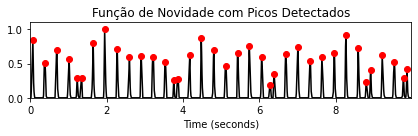

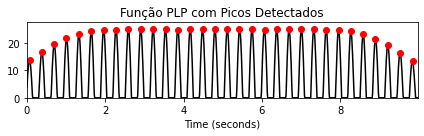

In [25]:
@jit(nopython=True)
def compute_plp(X, Fs, L, N, H, Theta):
    """ Computa a função PLP (Pulso Local Predominante) usando sinusoides janeladas com fase ótima.
    Args:
        X (np.ndarray): Tempograma baseado em Fourier (valores complexos)
        Fs (scalar): Taxa de amostragem
        L (int): Comprimento da curva de novidade
        N (int): Comprimento da janela
        H (int): Tamanho do salto (hop size)
        Theta (np.ndarray): Conjunto de tempos (em BPM)
    Returns:
        nov_PLP (np.ndarray): Função PLP resultante """
    # Gera uma janela Hanning de tamanho N
    win = np.hanning(N)
    
    # Calcula os tamanhos das janelas à esquerda e à direita para a sobreposição-acumulação
    N_left = N // 2
    L_left = N_left
    L_right = N_left
    
    # Calcula o comprimento total do sinal após o preenchimento com zeros (padding)
    L_pad = L + L_left + L_right
    
    # Inicializa a função PLP com zeros
    nov_PLP = np.zeros(L_pad)
    
    # Obtém o número de frames no tempograma
    M = X.shape[1]
    
    # Calcula o módulo (amplitude) do tempograma
    tempogram = np.abs(X)
    
    # Loop sobre cada frame do tempograma
    for n in range(M):
        # Encontra o índice da frequência (tempo) que maximiza a amplitude no frame atual
        k = np.argmax(tempogram[:, n])
        
        # Converte o índice de tempo em BPM para frequência angular (omega)
        tempo = Theta[k]
        omega = (tempo / 60) / Fs
        
        # Obtém o valor complexo no tempograma e calcula a fase correspondente
        c = X[k, n]
        phase = - np.angle(c) / (2 * np.pi)
        
        # Define os limites da janela de tempo
        t_0 = n * H
        t_1 = t_0 + N
        
        # Gera o eixo de tempo para a sinusoide
        t_kernel = np.arange(t_0, t_1)
        
        # Calcula a sinusoide janelada com a fase ótima
        kernel = win * np.cos(2 * np.pi * (t_kernel * omega - phase))
        
        # Acumula a sinusoide na função PLP
        nov_PLP[t_kernel] = nov_PLP[t_kernel] + kernel
    
    # Remove o preenchimento com zeros para obter a função PLP final
    nov_PLP = nov_PLP[L_left:L_pad-L_right]
    
    # Aplica retificação de meia onda (elimina valores negativos)
    nov_PLP[nov_PLP < 0] = 0
    
    return nov_PLP

# Carrega o arquivo de áudio
fn_wav = os.path.join('Audios', 'Luv(sic)_Part_3.mp3')
Fs = 22050
x, Fs = librosa.load(fn_wav) 
x = x[:Fs*10]

# Calcula o espectro de novidade e o reamostra
nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs, N=2048, H=512, gamma=100, M=10, norm=True)
nov, Fs_nov = libfmp.c6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

L = len(nov)
N = 500
H = 10
Theta = np.arange(30, 601)
X, T_coef, F_coef_BPM = libfmp.c6.compute_tempogram_fourier(nov, Fs=Fs_nov, N=N, H=H, Theta=Theta)

# Calcula a função PLP
nov_PLP = compute_plp(X, Fs_nov, L, N, H, Theta)

# Gera o eixo de tempo para o vetor de novidade
t_nov = np.arange(nov.shape[0]) / Fs_nov

# Detecta picos na função de novidade
peaks, properties = signal.find_peaks(nov, prominence=0.02)
peaks_sec = t_nov[peaks]

# Plota a função de novidade com os picos detectados
libfmp.b.plot_signal(nov, Fs_nov, color='k', title='Função de Novidade com Picos Detectados')
plt.plot(peaks_sec, nov[peaks], 'ro')
plt.show()

# Gera uma sonificação dos picos detectados na função de novidade
x_peaks = librosa.clicks(times=peaks_sec, sr=Fs,length=len(x))
ipd.display(ipd.Audio(x + x_peaks, rate=Fs))

# Detecta picos na função PLP
peaks, properties = signal.find_peaks(nov_PLP, prominence=0.02)
peaks_sec = t_nov[peaks]

# Plota a função PLP com os picos detectados
libfmp.b.plot_signal(nov_PLP, Fs_nov, color='k', title='Função PLP com Picos Detectados')
plt.plot(peaks_sec, nov_PLP[peaks], 'ro')
plt.show()

# Gera uma sonificação dos picos detectados na função PLP
x_peaks = librosa.clicks(times=peaks_sec, sr=Fs, click_freq=1000, length=len(x))
ipd.display(ipd.Audio(x + x_peaks, rate=Fs))
